# Starry Star Spots Monte Carlo Markov Chain

### Monte Carlo Markov Chain

<img src="1.png" alt="Alternative text" />

Monte Carlo methods use random sampling to predict outcomes of an uncertain event

A Markov Chain is a stochastic model for a sequence of events where the state of events is dependent only on the state of previous events

Putting these together, we have the Monte Carlo Markov Chain algorithm

### Starry

<img src="2.png" alt="Alternative text" />

Starry is a package designed to map stars and exoplanets using timeseries data

### Get the Package Working

Create a new conda environment from the provided .yml file by running the following command in your terminal:

conda env create --name starry --file=starry.yml

### Running the MCMC

In [2]:
### Import Packages

import matplotlib.pyplot as plt
import numpy as np
import starry
from scipy.interpolate import interp1d
from scipy.linalg import block_diag
import theano
import theano.tensor as tt
import theano.sparse as ts
import math
import tqdm
import emcee
from multiprocess import Pool
import time

### Starry options
starry.config.lazy = False
starry.config.quiet = True

#### Using MCMC for the parameters contrast and spot fraction

##### Generate real light curve to optimize

The contrast_real and fspot_real are parameters that the user can choose

If lat and lon are changed, radius_max will need to be as well

In [3]:
contrast_real=0.5 # set the real contrast of star spot
fspot_real = 0.5 # set the real spot fraction of star spot
lat = 0 # set latitude of star spot
lon = 0 # set longitude of star spot
radius_max = np.sqrt(180**2 + 45**2) # calculate radius max; if lat/lon is changed, this will as well
t = np.linspace(0,10,50) # generate time array for light curve

##### Generating a map, and then a star spot to extract light curve from

In [4]:
map=starry.Map(ydeg=5,reflected=False)
map.spot(contrast=contrast_real, radius=fspot_real*radius_max,lat=lat,lon=lon)
light_curve_real = np.array(map.flux(theta=360/10*t))

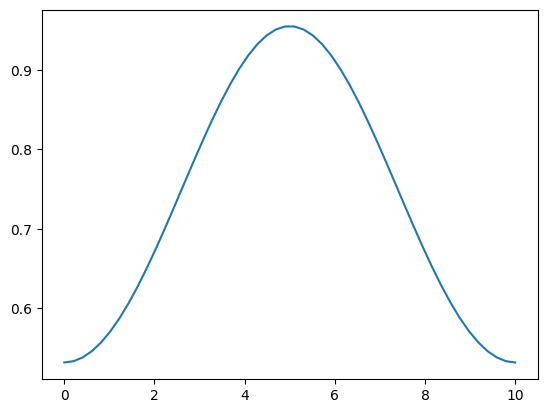

In [5]:
plt.plot(t,light_curve_real)
plt.show()

#### Applying the MCMC

##### Calculating $\chi^2$

In [6]:
def Xi_squared(theta_fake):
    contrast_fake,fspot_fake = theta_fake
    map=starry.Map(ydeg=1,reflected=False)
    map.spot(contrast=contrast_fake, radius=fspot_fake*radius_max,lat=lat,lon=lon)
    return np.sum((light_curve_real - np.array(map.flux(theta=360/10*t)))**2)

##### Calculating $\log{L}$

We want $\chi^2$ to be small, in order to maximize $\log{L}$

To maximize the posterior, we need to calculate $\log{L}\times\text{prior}$

theta is our parameters; contrast and fspot

In [7]:
def log_likelihood(theta):
    return -0.5 * Xi_squared(theta) # minimizing ki**2

##### Calculating $\log{\text{Prior}}$

In [8]:
def log_prior(theta):
    contrast, fspot = theta
    if 0 < contrast < 1 and 0.0 < fspot < 1:
        return 0.0
    return -np.inf

##### Defining the probability

In [9]:
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

##### Setting the initial guess for our parameters

In [10]:
contrast_initial = 0.2
fspot_initial = 0.2

##### Calculating the probability

In [11]:
log_probability([contrast_initial,fspot_initial])

-1.6126373414331692

##### Calculating the random walk

In [33]:
### 64 walks & 1000 steps

pos = [contrast_initial,fspot_initial]+ 1e-3 * np.random.randn(64, 2) # Guess of initial value for fpost and contrast, 1e-3 changes starting value
nwalkers, ndim = pos.shape


with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,pool=pool)
    start = time.time()
    sampler.run_mcmc(pos, 1000, progress=True);
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

100%|███████████████████████████████████████| 1000/1000 [45:42<00:00,  2.74s/it]


Multiprocessing took 2745.3 seconds


In [34]:
print(nwalkers, ndim)

64 2


##### Plotting the results

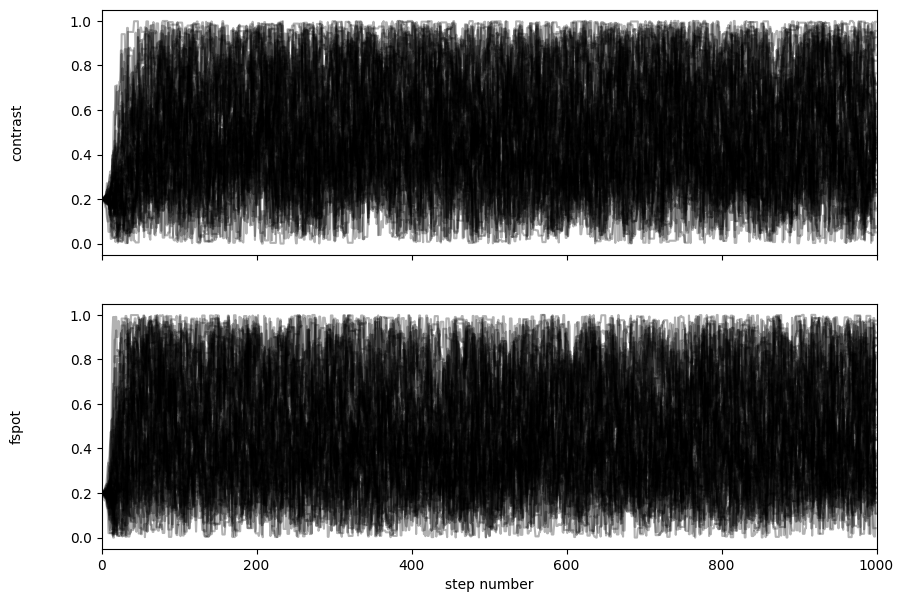

In [35]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["contrast", "fspot"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [36]:
flat_samples = sampler.get_chain(discard=50, thin=1, flat=True)
print(flat_samples.shape)

(60800, 2)


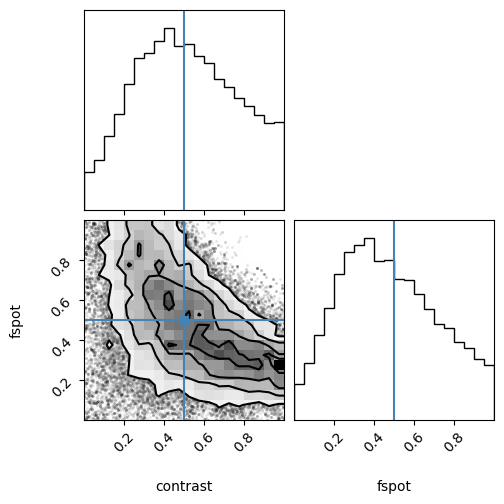

In [37]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[contrast_real, fspot_real]
);

In [12]:
### 64 walks & 100 steps

pos = [contrast_initial,fspot_initial]+ 1e-3 * np.random.randn(64, 2) # Guess of initial value for fpost and contrast, 1e-3 changes starting value
nwalkers, ndim = pos.shape


with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,pool=pool)
    start = time.time()
    sampler.run_mcmc(pos, 100, progress=True);
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

100%|█████████████████████████████████████████| 100/100 [02:42<00:00,  1.62s/it]

Multiprocessing took 164.4 seconds


In [17]:
164.4/2745.3

0.05988416566495465

In [13]:
print(nwalkers, ndim)

64 2


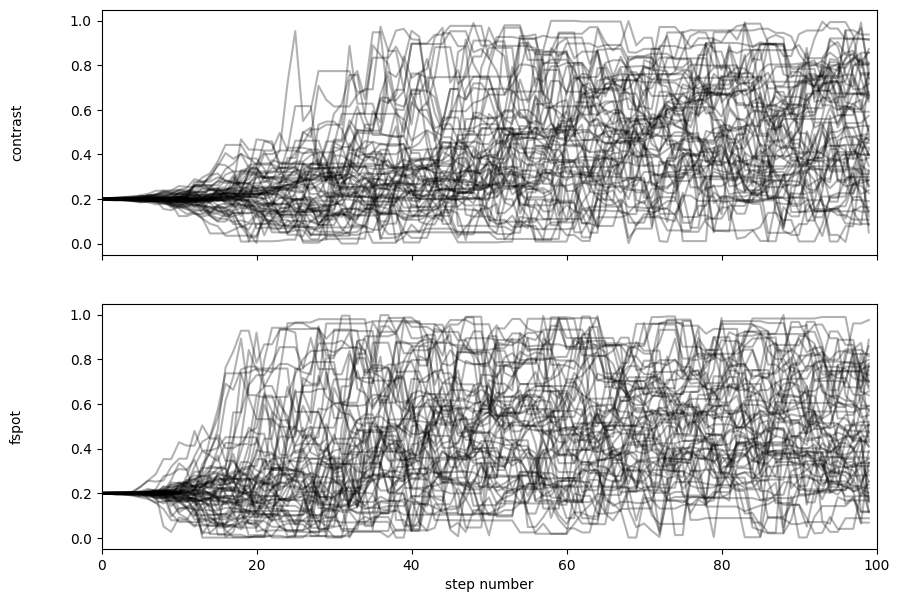

In [14]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["contrast", "fspot"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [15]:
flat_samples = sampler.get_chain(discard=50, thin=1, flat=True)
print(flat_samples.shape)

(3200, 2)


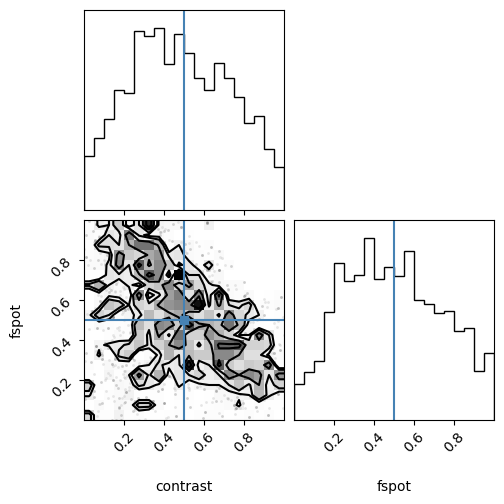

In [16]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[contrast_real, fspot_real]
);

### Future Work

<img src="3.png" alt="Alternative text" />

- Add more parameters: latitude, longitude
- More steps